The purpose of this notebook is to understand what drives the North-South variation in rainfall during SALLJ events; it is hoped that this will shed light on the drivers of extreme rainfall in Paraguay in 2015-16.

In [1]:
import xarray as xr
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import datetime
import glob
import pandas as pd
from scipy.stats import spearmanr
from paraguayfloodspy.xrutil import *
from paraguayfloodspy.pars import GetPars
import paraguayfloodspy.visualize as viz
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
%matplotlib inline

Set a few parameters

In [2]:
pars = GetPars('all')
lonmin = pars['wt_rgn']['lonmin']
lonmax = pars['wt_rgn']['lonmax']
latmin = pars['wt_rgn']['latmin']
latmax = pars['wt_rgn']['latmax']

Infer 

In [3]:
plt.style.use('ggplot')

Read in the raw data.
This data is the 850 hPa streamflow function $\psi$ which has been filtered to take the anomalies against the monthly 1980-2010 climatologies.

In [4]:
psi850 = SelectData(xr.open_dataarray("../_data/reanalysis/subset/streamfunc_850_anom.nc"),
                    extent=[lonmin, lonmax, latmin, latmax], y_low_high=True)
psi850

<xarray.DataArray 'streamfunction' (time: 4486, lat: 7, lon: 9)>
[282618 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -15.0 -17.5 -20.0 -22.5 -25.0 -27.5 -30.0
  * lon      (lon) float32 295.0 297.5 300.0 302.5 305.0 307.5 310.0 312.5 315.0
  * time     (time) datetime64[ns] 1979-11-01 1979-11-02 1979-11-03 ...
    month    (time) int64 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 ...

## EOFs

The next step of our analysis is to take the leading EOFs of this data.

In [5]:
solver = Eof(psi850, center=True)

We'll put together reconstructions using the leading 4 EOFs, which is what the Weather Typing algorithm said covered 95% of the variance (using the same EOF decomposition of the same data, ie the same thing!)

In [6]:
neof=4

/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:413: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})


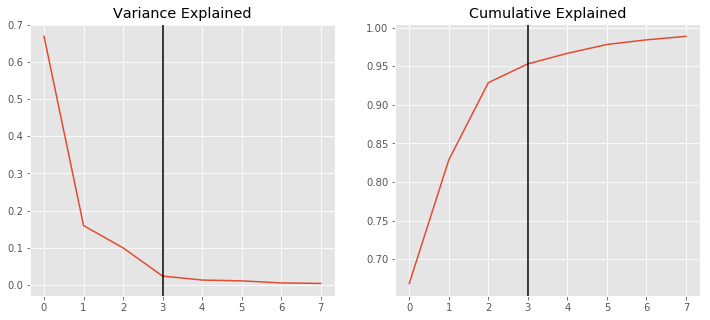

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(solver.varianceFraction(neigs=2*neof).values)
plt.axvline(neof-1, c='k')
plt.title("Variance Explained")
plt.subplot(1,2,2)
plt.plot(np.cumsum(solver.varianceFraction(neigs=2*neof).values))
plt.axvline(neof-1, c='k')
plt.title("Cumulative Explained")

Now visualize these loadings

In [8]:
loading = solver.eofs(neofs=neof)

/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:224: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})


/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


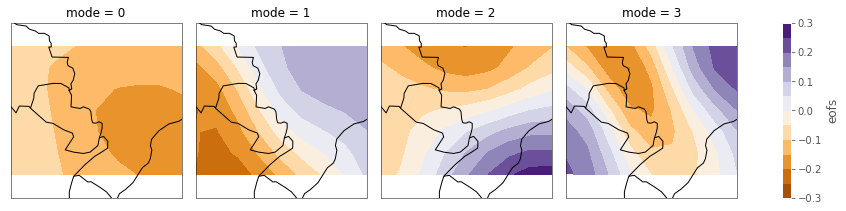

In [9]:
p = loading.plot.contourf(
    transform=ccrs.PlateCarree(), cmap='PuOr',
    col='mode', col_wrap=4, levels=np.linspace(-.3, .3, 13),
    subplot_kws={'projection': ccrs.PlateCarree()},
)
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent((lonmin, lonmax, latmin, latmax))
    ax.add_feature(cartopy.feature.BORDERS)

Looking at these, EOF `mode = 2` looks like a likely culprit! 
Look at how it deflects the jet to the ENE or SSW depending on its sign!
Let's get the time series of these EOFs.

## Exploring EOF 2

In [10]:
pcs = solver.pcs(npcs=neof).to_pandas()

/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:178: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})


Now read in rainfall data and compute averages over two boxes, one corresponding approximately to Southern Paraguay and the other approximately to Uruguay.

In [11]:
prcp = xr.open_dataarray("../_data/rainfall/subset/cpc_raw.nc")

In [12]:
prcp_rpy = prcp.sel(lon = slice(301.25, 304.75), lat = slice(-26.75, -22.75)).mean(dim=['lon', 'lat'])
prcp_rpy = prcp_rpy.to_pandas()
prcp_rpy = pd.DataFrame({'prcp_rpy': prcp_rpy})

In [13]:
prcp_uru = prcp.sel(lon = slice(301.25, 304.75), lat = slice(-34.75, -30.75)).mean(dim=['lon', 'lat'])
prcp_uru = prcp_uru.to_pandas()
prcp_uru = pd.DataFrame({'prcp_uru': prcp_uru})

In [14]:
df = pcs.join(prcp_rpy).join(prcp_uru)
df = df.dropna()
df.head()

,0,1,2,3,prcp_rpy,prcp_uru
time,,,,,,
1979-11-01,-1.566870e+07,-5974721.500,4373269.50,2020148.375,8.292169,1.824569
1979-11-02,-7.708023e+06,8463980.000,-7133570.50,3787307.250,0.107124,0.019316
1979-11-03,-1.317780e+07,-1122369.375,-5043125.50,-2340445.000,0.060489,0.004598
1979-11-04,-5.629856e+04,3522403.000,2523451.25,-2367298.500,0.190260,1.246967
1979-11-05,4.395624e+06,4604161.000,-4675853.00,3241233.000,0.012385,24.984872


Correlation is obviously a limited tool, but let's see how the EOFs are correlated (daily time step) with the rainfall data

In [15]:
print('Spearman rank correlation between URU and RPY Data:')
print(spearmanr(df[['prcp_uru']], df[['prcp_rpy']])[0])
for i in range(neof):
    print('Spearman rank correlation between EOF {} and RPY Data:'.format(i))
    print(spearmanr(df[[i]], df[['prcp_rpy']])[0])
    print('Spearman rank correlation between EOF {} and URU Data:'.format(i))
    print(spearmanr(df[[i]], df[['prcp_uru']])[0])

Spearman rank correlation between URU and RPY Data:
0.270098367119
Spearman rank correlation between EOF 0 and RPY Data:
0.068913944156
Spearman rank correlation between EOF 0 and URU Data:
0.138596968664
Spearman rank correlation between EOF 1 and RPY Data:
-0.423792070619
Spearman rank correlation between EOF 1 and URU Data:
-0.555109230633
Spearman rank correlation between EOF 2 and RPY Data:
0.187205355225
Spearman rank correlation between EOF 2 and URU Data:
-0.0472313396096
Spearman rank correlation between EOF 3 and RPY Data:
-0.0286368298372
Spearman rank correlation between EOF 3 and URU Data:
0.179278228804


## KNN

Now let's look at whether, given EOFs 1 and 2 (EOF 1 corresponds to a jet event and EOF 2 to whether it penetrates S or to the E -- see above) we can predict rainfall in the two boxes.

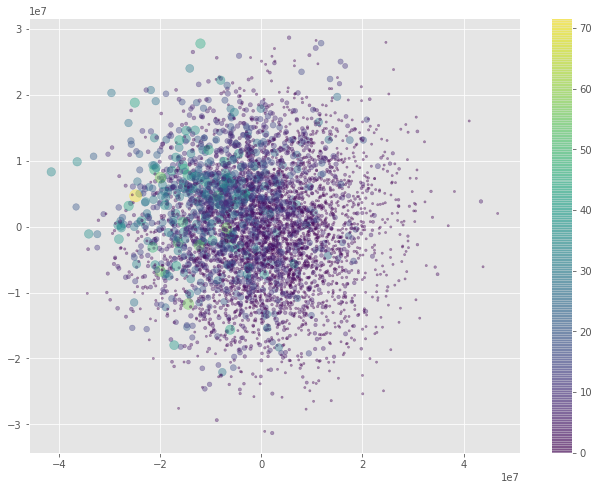

In [16]:
plt.figure(figsize=(11,8))
plt.scatter(df[[1]], df[[2]], s=5+2*df[['prcp_rpy']], c=df[['prcp_rpy']], alpha=0.4)
plt.colorbar()

In [17]:
X = df[[1, 2]].values
neigh = KNeighborsRegressor(n_neighbors=100)
x = np.arange(-2.5e7, 2.5e7, .75e6)
x,y = np.meshgrid(x,x)
Xnew = np.array([np.hstack(x), np.hstack(y)]).transpose()
X1new = np.reshape(Xnew[:,0], x.shape)
X2new = np.reshape(Xnew[:,1], x.shape)

Do it for the Paraguay River Basin

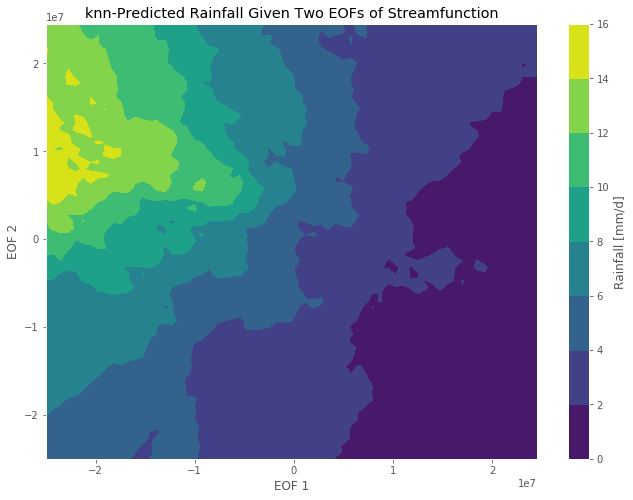

In [18]:
y = df[['prcp_rpy']].values
knnfit = neigh.fit(X,y)
ynew = knnfit.predict(Xnew)
ynew = np.reshape(ynew, x.shape)
plt.figure(figsize=(11,8))
C = plt.contourf(X1new, X2new, ynew, levels=np.linspace(0,16,9))
plt.xlabel("EOF 1")
plt.ylabel("EOF 2")
cb = plt.colorbar(C)
cb.set_label("Rainfall [mm/d]")
plt.title("knn-Predicted Rainfall Given Two EOFs of Streamfunction")

Now repeat for the other box

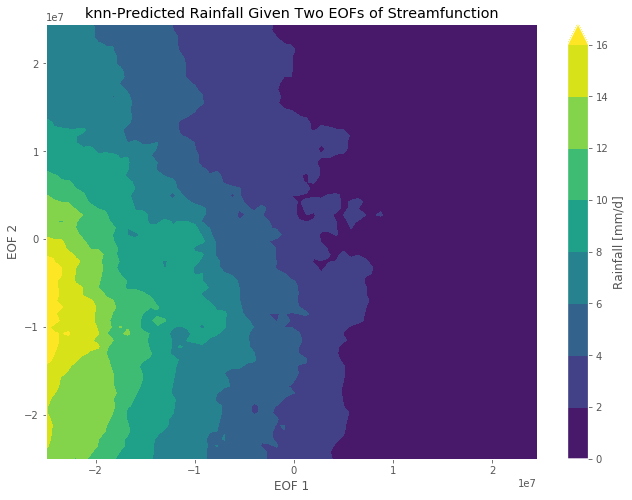

In [19]:
y = df[['prcp_uru']].values
knnfit = neigh.fit(X,y)
ynew = knnfit.predict(Xnew)
ynew = np.reshape(ynew, x.shape)
plt.figure(figsize=(11,8))
C = plt.contourf(X1new, X2new, ynew, levels=np.linspace(0,16,9), extend="max")
plt.xlabel("EOF 1")
plt.ylabel("EOF 2")
cb = plt.colorbar(C)
cb.set_label("Rainfall [mm/d]")
plt.title("knn-Predicted Rainfall Given Two EOFs of Streamfunction")

So we can see that in this limited-dimension space, EOF 1 controls the potential for rainfall but EOF 2 controls whether it is in RPY or URU.
This is exactly what we thought above!
When EOF1 is positive (no jet), there is no rainfall in either region and when EOF1 is negative (jet) there is rainfall somewhere.
However, when EOF2 is negative the jet extends far to the South and the rainfall occurs over Uruguay; when EOF2 is positive the jet doesn't penetrate and the intense rainfall occurs in Paraguay.

Just to make sure we're not tricking ourselves, let's composite rainfall for four cases:
EOF1 > 1, EOF2 > 1; 
EOF1 < -1, EOF2 > 1;
EOF1 > 1, EOF2 < -1;
EOF1 < -1, EOF2 < -1.

In [20]:
case_1 = np.logical_and(df[1] > 1, df[2] > 1)
case_1 = df.loc[case_1].index
#
case_2 = np.logical_and(df[1] < -1, df[2] > 1)
case_2 = df.loc[case_2].index
#
case_3 = np.logical_and(df[1] > 1, df[2] < -1)
case_3 = df.loc[case_3].index
#
case_4 = np.logical_and(df[1] < -1, df[2] < -1)
case_4 = df.loc[case_4].index

This confirms!
For cases 1 and 3, EOF 1 is positive (and large) so there is not jet --> no rainfall in either location.
For cases 2 and 4, there is a strong jet and the maximum rainfall is controlled by EOF 2.

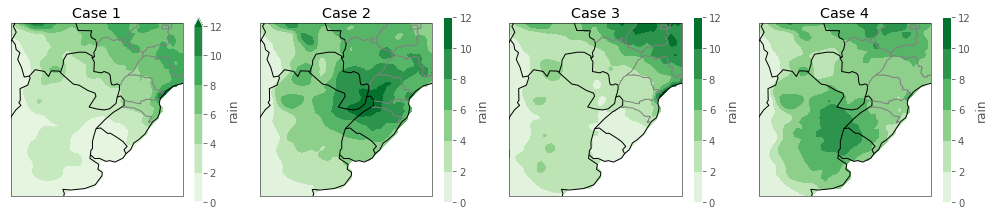

In [21]:
fig, axes = viz.SetupAxes(nax=4, ncol=4, proj=ccrs.PlateCarree(), figsize=(14, 3))
for i,case in enumerate([case_1, case_2, case_3, case_4]):
    selector = lambda ds: ds.sel(lon = slice(290, 315), lat = slice(-40, -15)).sel(time = case).mean(dim= 'time')
    ax = viz.GetRowCol(i, axes)
    selector(prcp).plot.contourf(transform = ccrs.PlateCarree(), ax=ax, levels=np.linspace(0,12,7), cmap="Greens")
    ax.set_title("Case {}".format(i+1))
viz.FormatAxes(axes, states=True)

COnfirmed

## Case Studies

Let's see this difference for some ENSO years -- sometimes staring at data is healthy (other times it's a waste of time)

In [22]:
enso_years = np.array([1982, 1997, 1986, 1987, 1991, 2002, 2009, 2015])
enso_years = np.sort(enso_years)

1982


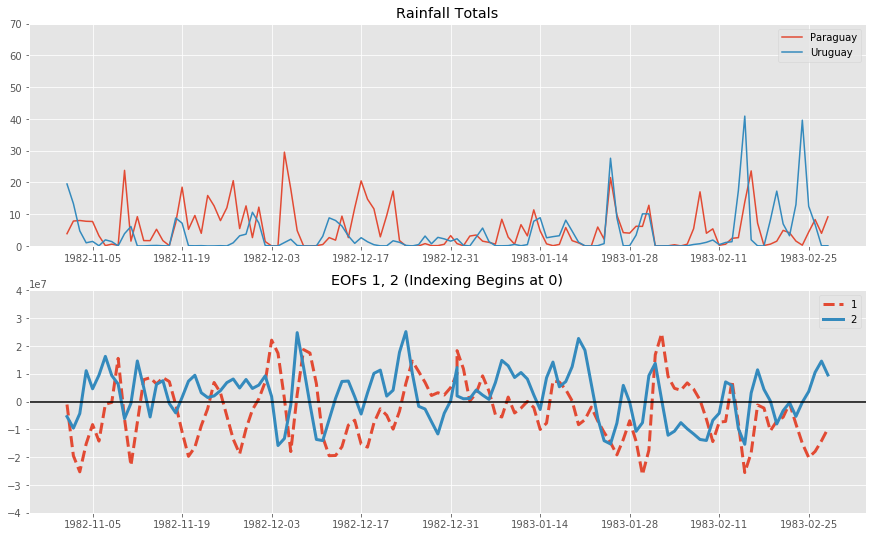

1986


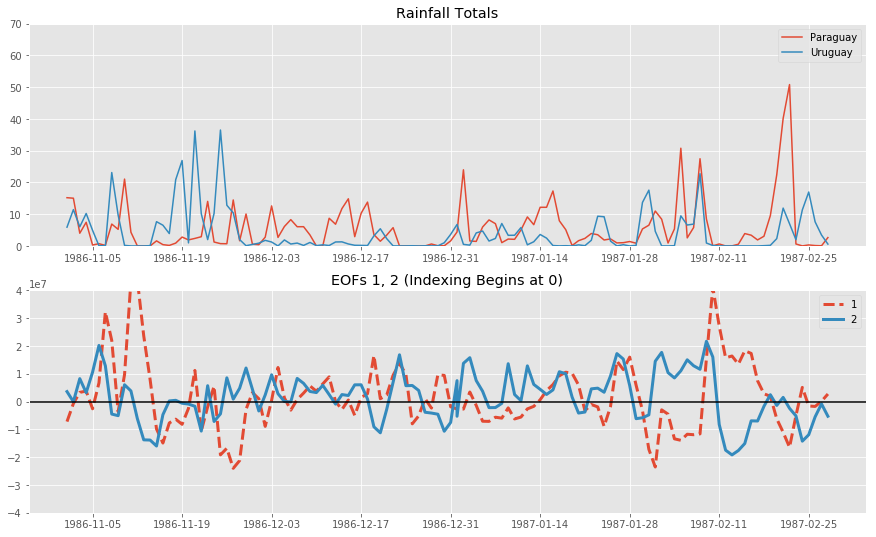

1987


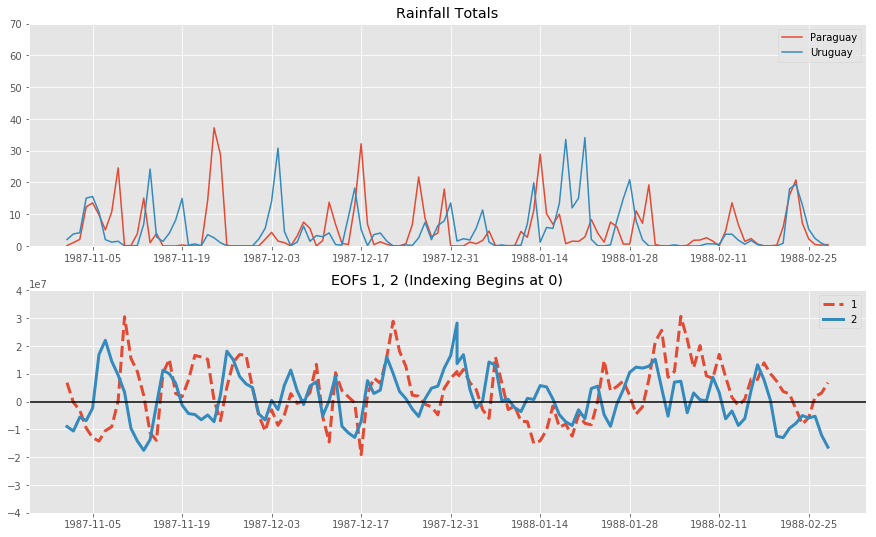

1991


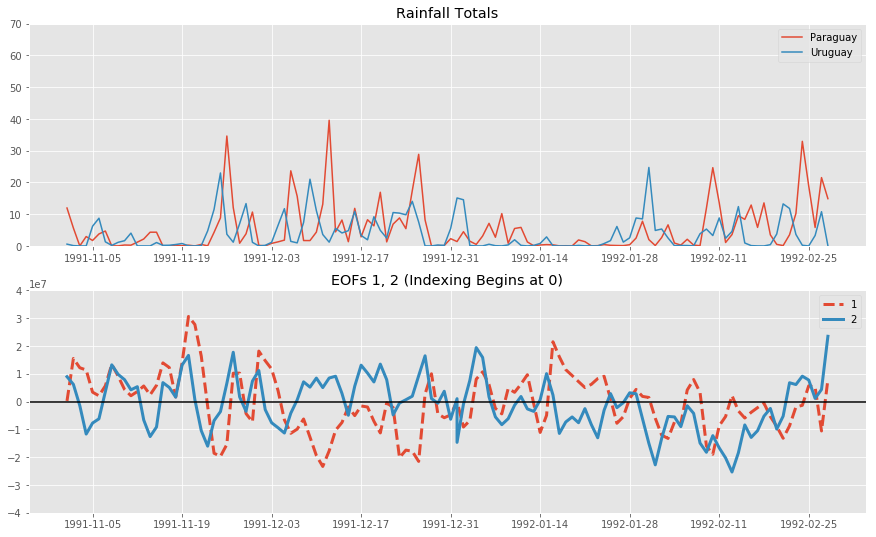

1997


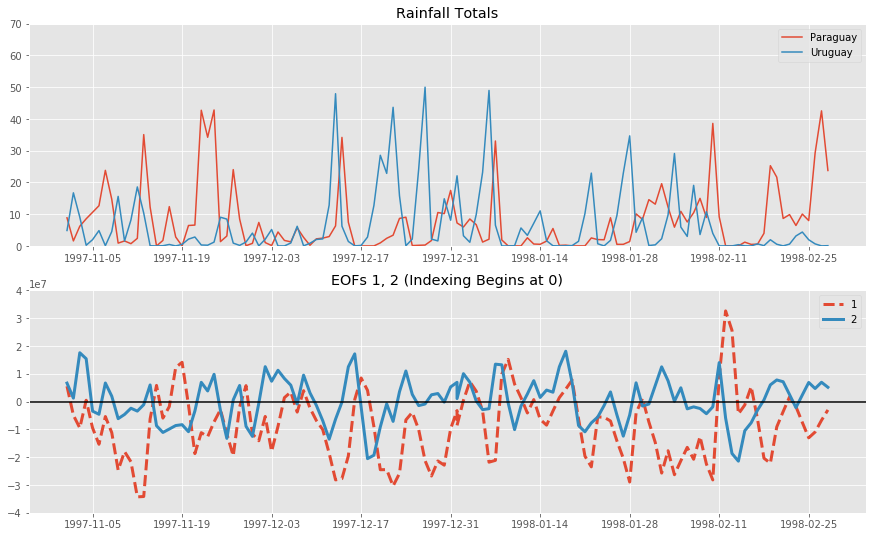

2002


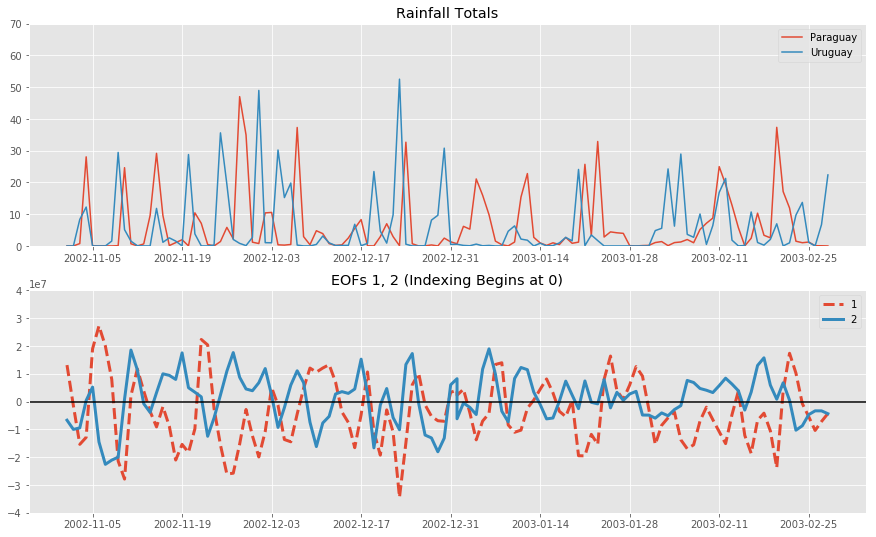

2009


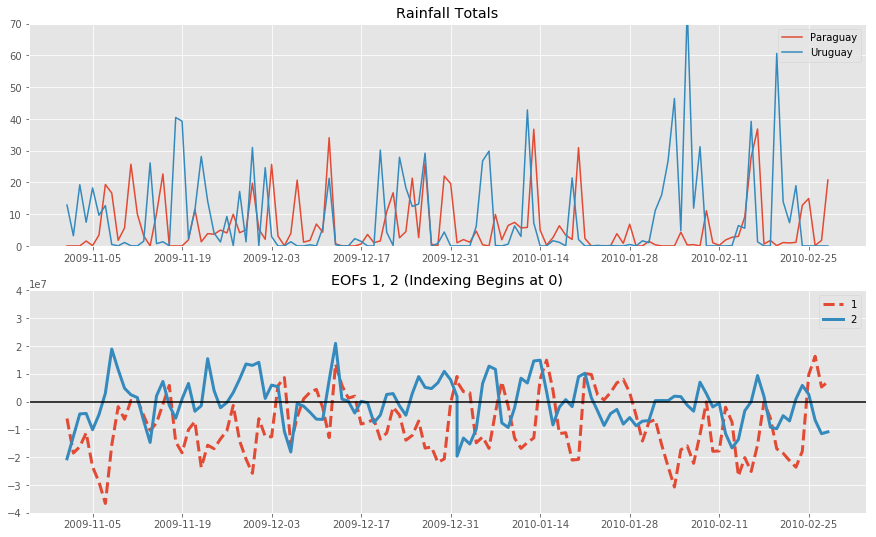

2015


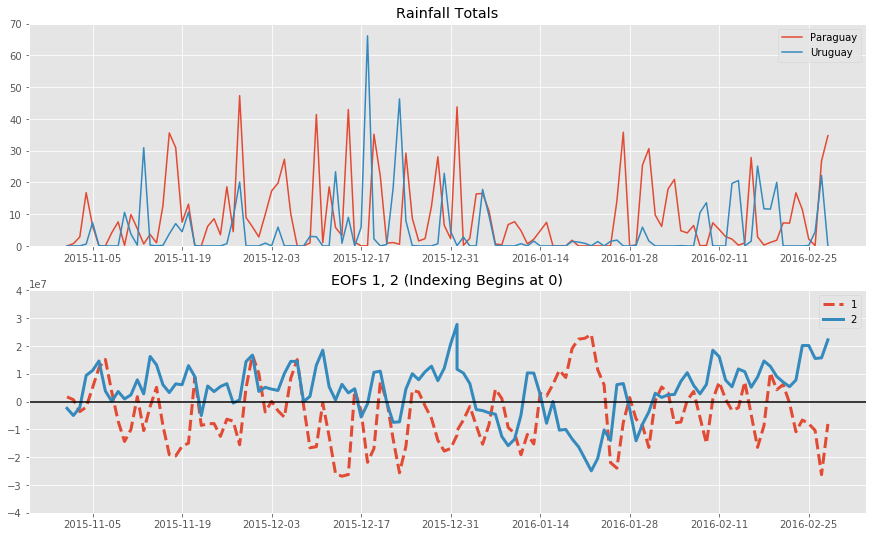

In [23]:
linestyles = ['-.', '--', '-', ':']
for y in enso_years:
    print(y)
    fig,axes = plt.subplots(nrows=2,  ncols=1, figsize=(15,9))
    sub = df['{}-11-01'.format(y):'{}-02-28'.format(y+1)]
    axes[0].plot(sub.index, sub['prcp_rpy'], label="Paraguay")
    axes[0].plot(sub.index, sub['prcp_uru'], label="Uruguay")
    axes[0].legend()
    axes[0].set_title("Rainfall Totals")
    axes[0].set_ylim(0,70)
    for i in [1,2]:
        #$axes[1].plot(sub.index, sub.rolling(7, center=True).mean()[[i]], label=i, linewidth=3, linestyle=linestyles[i])
        axes[1].plot(sub.index, sub[[i]], label=i, linewidth=3, linestyle=linestyles[i])
    axes[1].legend()
    axes[1].axhline(0, color='black')
    axes[1].set_title("EOFs 1, 2 (Indexing Begins at 0)")
    axes[1].set_ylim(-4e7,4e7)
    plt.show()

Is the difference statistically significant and/or meaningful?

In [24]:
sub = pd.DataFrame({'prcp_diff': df['prcp_rpy'] - df['prcp_uru']}).join(df[[2]])
sub = sub.dropna()

In [25]:
rho, p = spearmanr(sub[['prcp_diff']], sub[[2]])
print("Correlation between this difference and EOF 2 is {:3f}, p-value {}".format(rho, p))

Correlation between this difference and EOF 2 is 0.212079, p-value 1.758790028847291e-47


Absolutely!

## Meaning

A valid interpretation is thus that, to a leading order of approximation, differences in rainfall location (Paraguay River Basin or Uruguay) are linked (as found in the literature) to different types of jet events.
Using the chosen domain, this corresponds to the first two EOFs of the streamfunction field (which is for all intents and purposes quite close to the geopotential height field).

It will still be interesting to examine relation of this EOF with other climate fields of interest and to see whether 